Welcome to the [Feedback Prize - English Language Learning](https://www.kaggle.com/competitions/feedback-prize-english-language-learning) competition by [The Learning Agency Lab](https://www.the-learning-agency-lab.com/).

<img src="https://www.the-learning-agency.com/wp-content/uploads/2021/03/TLA_Labs_Color__LG.png" width=500>

<hr>

This is the third competition in the Feedback series. Here are the links to the first two:

* 1st: [Feedback Prize - Evaluating Student Writing](https://www.kaggle.com/c/feedback-prize-2021)
* 2nd: [Feedback Prize - Predicting Effective Arguments](https://www.kaggle.com/c/feedback-prize-effectiveness) 

My goal in this notebook is to explore this competition's data, then start the competition off with a strong baseline, based on the work I did in the [last Feedback competition](https://www.kaggle.com/code/lextoumbourou/feedback-deberta-xlarge-0-588-public-lb).

This notebook includes a few interesting goodies:
* A highly customised `Trainer` from the HuggingFace `transformers` library.
* An example of adversarial training using SiFT from the DeBERTa paper.
* A working example of TokenDropout.
* Mean/Max/Min Pooling layers.

# Competition Overview

From the [Competition Description](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview/description):

*The goal of this competition is to assess the language proficiency of 8th-12th grade English Language Learners (ELLs). Utilizing a dataset of essays written by ELLs will help to develop proficiency models that better supports all students.*

*Your work will help ELLs receive more accurate feedback on their language development and expedite the grading cycle for teachers. These outcomes could enable ELLs to receive more appropriate learning tasks that will help them improve their English language proficiency.*

# Metric

Solutions are evaluated using MCRMSE: mean columnwise root mean squared error.

$$
\text{MCRMSE} = \frac{1}{\color{magenta}{N_t}}  \sum\limits^{\color{magenta}{N_t}}_{j=1} \sqrt{ \frac{1}{n} \sum\limits^{\color{teal}{n}}_{i=1} (\color{olive}{y}_{ij} - \color{orange}{\hat{y}}_{ij})^2 }
$$

Where

* $\color{magenta}{N_t}$ - the number of label columns.
* $\color{teal}{n}$ - number of rows.
* $\color{olive}{y}$ - the actual predictions
* $\color{orange}{\hat{y}}$ is the predicted values.

In other words, take the root mean squared error of each column, then average together for the final metric.

In code:

```python

```

In [1]:
import numpy as np

def mcrmse(targets, predictions):
    error = targets - predictions
    squared_error = np.square(error)
    colwise_mse = np.mean(squared_error, axis=0)
    root_colwise_mse = np.sqrt(colwise_mse)
    return np.mean(root_colwise_mse, axis=0)

# Imports

Like my notebook from last competition, I will make use of the HuggingFace training toolkit, as well as their model library.

In [2]:
!pip install iterative-stratification &> /dev/null
!pip install wordcloud &> /dev/null

In [3]:
import logging
from types import SimpleNamespace
from pathlib import Path
from dataclasses import dataclass
from typing import Union, Optional
from torch import nn
import torch
from torch.nn import MSELoss

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from transformers.data.data_collator import DataCollatorMixin
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import PaddingStrategy
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, AutoModel
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import DataCollatorWithPadding
from wordcloud import WordCloud

# From this Gist: https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Load Data

In [4]:
train_df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')

Let's see a row from each dataset.

In [5]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


Then the size of each dataset.

In [7]:
len(train_df), len(test_df)

(3911, 3)

The train set only contains 3,911 texts.

The test set CSV only contains 3 texts, as the notebook needs to be submitted to run against the entire test set.

# Labels Overview

In [8]:
LABEL_COLUMNS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

Each datapoint has 6 labels, which are scores that describe proficiency in various compenents of essay writing.

* `cohesion`
* `syntax`
* `vocabulary`
* `phraseology`
* `grammar`
* `conventions`

The scores range from 1 - 5 in increments of 0.5.

Let's look at the distribution of each label value across the dataset.

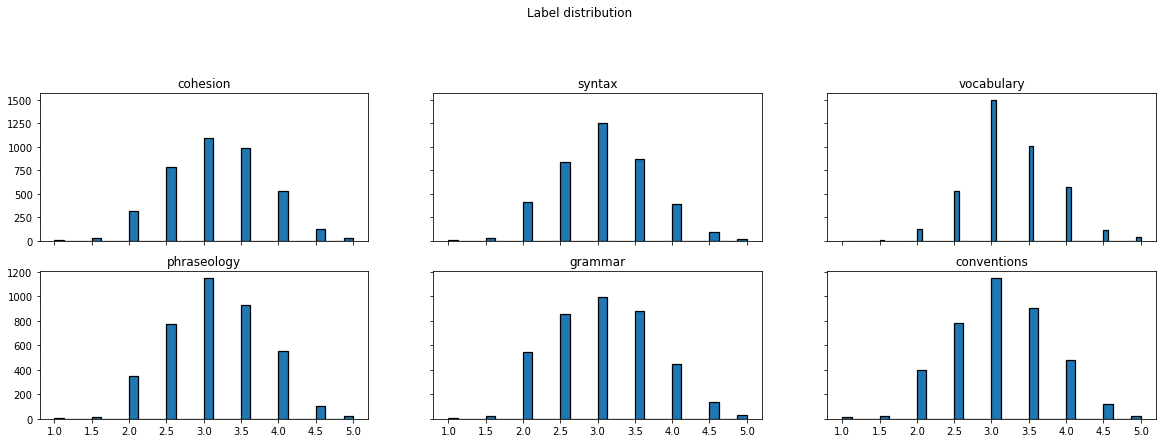

In [9]:
fig, axes = plt.subplots(2, len(LABEL_COLUMNS) // 2, sharex='col', sharey='row', figsize=(20, 6))

for i, label_col in enumerate(LABEL_COLUMNS):
    ax = axes.flat[i]
    sns.histplot(x=label_col, data=train_df, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(label_col)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Label distribution', y=1.08)
plt.show()

The labels appears to be normally distributed, though there are very examples of scores 1 and 1.5 across each label type.

Let's explore the correlations between the labels.

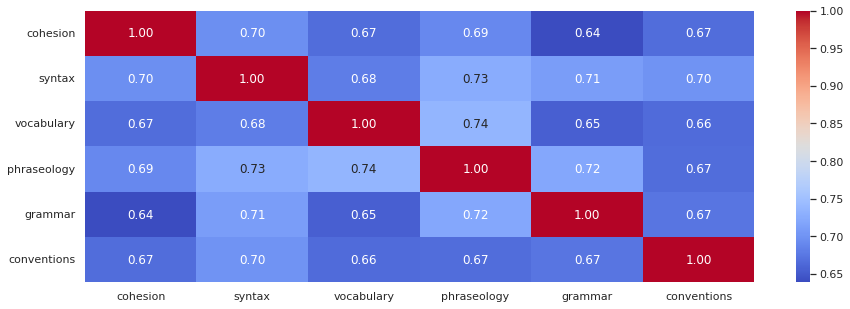

In [10]:
corr = train_df[LABEL_COLUMNS].corr()
sns.set(rc = {"figure.figsize": (15, 5)})

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

It seems that correlation is highest between `phraselogy` and `vocabulary`; as well as `phraselogy` and `syntax`.

# Text Examples

Let's see a few examples of the first 400 characters from each full text.

In [11]:
def print_texts(df):
    inner_html = ""
    for idx, row in df.iterrows():
        inner_html += f"""
        <td style="vertical-align:top; border-right: 1px solid #7accd8">
        <h3 style="text-align:left">{row.text_id}</h3>
        <hr>
            <dl>
                <dt>Cohesion</dt>
                <dd>{row.cohesion}</dd>
                
                <dt>Syntax</dt>
                <dd>{row.syntax}</dd>
                
                <dt>Vocabulary</dt>
                <dd>{row.vocabulary}</dd>
                
                <dt>Phraseology</dt>
                <dd>{row.phraseology}</dd>
                
                <dt>Grammar</dt>
                <dd>{row.grammar}</dd>
                
                <dt>Conventions</dt>
                <dd>{row.conventions}</dd>
            </dl>
            
            <hr>
            <p>
            {row.full_text[:400]}
            </p>
        </td>
        """

    display(HTML(f"""
    <table style="font-family: monospace;">
        <tr>
             {inner_html}
        </tr>
    </table>
    """))

## Random Examples

In [12]:
texts = train_df.sample(frac=1, random_state=420).head(4)

print_texts(texts)

67F6FEDD7677 Cohesion 2.5 Syntax 2.5 Vocabulary 2.5 Phraseology 2.0 Grammar 3.0 Conventions 2.0 Some schools have programs for youngers and olders student why they make programs like this or how can they help each others Okey. This program help both students to learn about what are the responsability of the olders students and the youngers student to see what they going to do when they becomes a older and the olders student can learn from de younger student. The olders student can teach abo,"C537E278BAE6 Cohesion 2.5 Syntax 2.5 Vocabulary 3.0 Phraseology 2.5 Grammar 2.5 Conventions 3.0 No they shouldn't add an hour more because we don't need the hour but they should completely change the time for waking up and getting ready to come to school at 8 because i feel like every kid will have energy and not fall asleep. also i think they should put each class an hour like example math should be an hour also Science , English , geography because all we honestly do need is come to schoo","F7CBE1D11BF8 Cohesion 3.5 Syntax 3.5 Vocabulary 3.0 Phraseology 3.0 Grammar 4.0 Conventions 4.0 Is true self-esteem caused by self-confidence or is it caused by achievement, are people right about what they believe that; self-esteem is caused by self-confidence or is self-esteem caused by achievements? Self-esteem is caused by achievements, although some people may believe self-esteem is caused by ""self-confidence"". I personally believe, self-esteem is caused by someone's achievement. By per","62F7911DE51F Cohesion 3.0 Syntax 3.0 Vocabulary 3.0 Phraseology 3.0 Grammar 2.5 Conventions 2.5 Once author Ralph Waldo Emerson Said ""unless you try to do somthing beyond what you have masterd you will never grow"", and he is right. To truly understand what thee author is trying to is saying you must understand that to say that you have mastered something is to be able to do it without failer. In order to grow you must set goals for your self. Even if those steps that you take are small they"


## Lowest Scoring Examples

In [13]:
train_df['total_score'] = train_df[LABEL_COLUMNS].sum(axis=1)
lowest_df = train_df.sort_values('total_score').head(4)

print_texts(lowest_df)

767533E12569 Cohesion 1.0 Syntax 1.0 Vocabulary 1.0 Phraseology 1.0 Grammar 1.0 Conventions 1.0 he is a good because they are the prescient and us. now the are more procession a other prescient and us. because and the more many education for student and school. the more school for one because he have a one women the have many education for a other because the good more the one is information for access because is not like the brazen giant of Greek fame with conquering one nation for is the i,48EA282A4EAF Cohesion 1.0 Syntax 1.0 Vocabulary 1.0 Phraseology 1.0 Grammar 1.0 Conventions 1.0 some student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. i think student would benefit form being able to attend classesfrom home. you are authorized take the electronic version of this you will taking this promptsome student offer distance learning as an option for student to attend classes from homr by wat of online pr vide,"DB2EA5C4828F Cohesion 1.0 Syntax 1.0 Vocabulary 1.5 Phraseology 1.0 Grammar 1.0 Conventions 1.0 Technology is positive, because is the good possibility for people the accomplish method system, the effect by people is have playing blow up when is play have a ball is very good for your health. the many person said the woman is not good that sport but the woman is very good for all along time. reading the books is good for your skull you think by relation in your life. never put down handle by",F69C85F4C3CA Cohesion 1.0 Syntax 1.0 Vocabulary 1.5 Phraseology 1.0 Grammar 1.0 Conventions 1.5 the memorable teacher ever had was a teacher in 10 word wild all students


## Highest Scoring Examples

In [14]:
train_df['total_score'] = train_df[LABEL_COLUMNS].sum(axis=1)
highest_df = train_df.sort_values('total_score', ascending=False).head(4)

print_texts(highest_df)

"B1AFACE6704E Cohesion 5.0 Syntax 5.0 Vocabulary 5.0 Phraseology 5.0 Grammar 5.0 Conventions 5.0 I agree with Michelangelo's statement as I have found through experience that it benefits me more to set high expectations and not reach my goal, rather than settling on a low goal and achieving it. When setting high goals, I find that I learn more and progress my abilties further than I do with a lower goal. This is because setting high goals requires confidence, challenges, and pride. Firstly,","52DC3B7C3952 Cohesion 5.0 Syntax 5.0 Vocabulary 4.5 Phraseology 5.0 Grammar 5.0 Conventions 5.0 Working From Home Should students be allowed to attend classes from home? I agree that attending classes while at home would be beneficial for many people and can actually help them work better. One reason is that it would be less stressful for the student and put a lot less pressure into getting the work done. Another reason is that it would give them more time to work, for example they could re","12E3D52345C6 Cohesion 5.0 Syntax 5.0 Vocabulary 5.0 Phraseology 5.0 Grammar 4.5 Conventions 5.0 Technology has always acted as a compelling and mysterious field for me. Even as a child, I spent countless hours not playing my video-game consoles as intended, but rather meticulously studying every component of the device in an attempt to crack the mystery on how it operated. Despite the fact that I've grown older and many aspects of my life have changed, my passion for technology has not only","5132328226C2 Cohesion 5.0 Syntax 5.0 Vocabulary 5.0 Phraseology 5.0 Grammar 4.5 Conventions 4.5 Afterschool Homework Club Most students do not enjoy doing their homework at home; for it can get quite frustrating. A lot of students favorite part of their school day is going home, but some other students favorite part of the day is their afterschool club. Now teachers and students are volunteering to meet with people who have difficulty in subjects or who want to finish their homework early,b"


# Text Overview

## Word Count

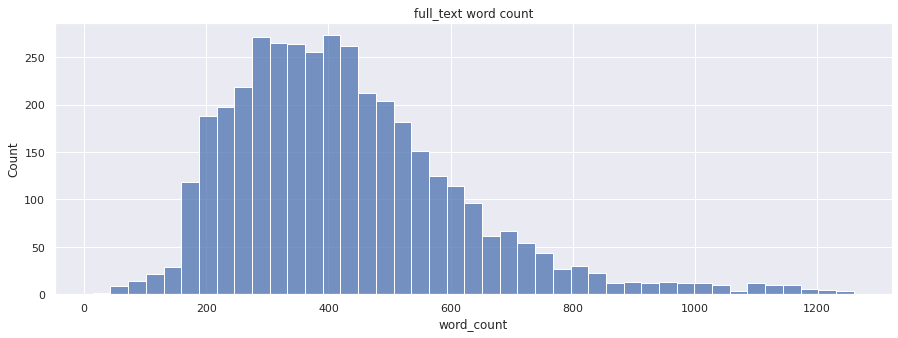

In [15]:
fig = plt.figure(figsize=(15, 5))
train_df['word_count'] = train_df.full_text.apply(lambda x: len(x.split()))
sns.histplot(data=train_df, x="word_count")
plt.title("full_text word count")
plt.show()

Mean word count:

In [16]:
train_df['word_count'].mean()

430.4929685502429

Max word count:

In [17]:
train_df['word_count'].max()

1260

## Word Cloud

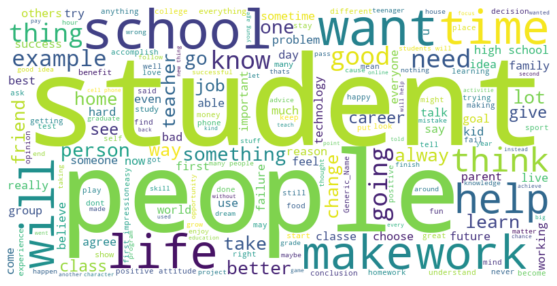

In [18]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(train_df.full_text))
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Config

This config is based off my model from last competition. There's a few things to note:

* `deberta-v3-large` - a strong starting baseline model, which improves slightly upon `deberta-v3-base` in my tests.
* `replace_newline` - Deberta v2/3 tokeniser removes the `\n` newline character. This can make it hard for the model to differential between discourse elements, so it can help to replace with a special character before training.
* `gradient_checkpointing` - significantly reduces the amount of memory required to train a NLP model. I highly recommend it. See [paper](https://arxiv.org/abs/1604.06174v2).
* `backbone_lr_fraction` to set the backbone to be a fraction of the head's learning rate. Initially just using the parameter that worked best last competition.
* `gradient_accumulation_steps` - number of steps to accumulate gradients for. This allows the model to treat small batch sizes as if they were large.
* `group_by_size` - significantly speeds up training by grouping samples of the same length. This works because I'm using dynamic padding.
* `folds_to_train` - for speed, i'm only training 2 out of 5 folds.
* `token_dropout_prob` - when set > 0, it replace tokens with `[MASK]` some % of the time. In the last competition, this helped to reduce overfitting quite a lot. However, so far it doesn't seem to help.
* `start_adv_training_on_epoch` - start adversarial training on this epoch.

In [19]:
config = SimpleNamespace()

config.seed = 420
config.model_name = 'microsoft/deberta-v3-large'
config.output_path = Path('./')
config.input_path = Path('../input/feedback-prize-english-language-learning')
config.tmp_path = Path('/kaggle/temp/')

config.n_folds = 4

config.epochs = 3

config.max_len = 512

config.eval_per_epoch = 2
config.replace_newline = '[BR]'
config.add_prefix_space = False
config.folds_to_train = {0,1,2,3}

config.bilstm_layer = False

config.batch_size = 4
config.gradient_accumulation_steps = 4
config.group_by_length = True
config.gradient_checkpointing = True

config.lr = 1e-5
config.backbone_lr_fraction = 1

config.warm_up_ratio = 0.
config.weight_decay = 0.01

config.hidden_dropout_prob = 0.
config.token_dropout_prob = 0.
config.attention_probs_dropout_prob = 0

config.start_adv_training_on_epoch = 1

logging.disable(logging.WARNING)

seed_everything(config.seed)

In [20]:
config.tmp_path.mkdir(exist_ok=True, parents=True)

# Setup CV

Using multi-label stratified fold thanks to the [kernel by Abhishek](https://www.kaggle.com/code/abhishek/multi-label-stratified-folds)

In [21]:
kfolds = MultilabelStratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=420)

train_df['fold'] = -1
for fold_num, (train_idxs, test_idxs) in enumerate(kfolds.split(train_df.index, train_df[LABEL_COLUMNS].values)):
    train_df.loc[test_idxs, ['fold']] = fold_num

In [22]:
train_df.fold.value_counts()

0    978
3    978
1    978
2    977
Name: fold, dtype: int64

In [23]:
train_df.to_csv(config.output_path / 'train_folds.csv', index=False)

# Data Prep and Tokenisation

Deberta-v2 and v3 models strips `\n` characters. In the last 2 competitions, it was a useful feature for the model to differentiate between discourse sections, so it can be useful to replace with a special character.

In [24]:
def maybe_replace_newline(text):
    if config.replace_newline:
        text = text.replace('\n', config.replace_newline)

    return text

In [25]:
all_special_tokens = []
if config.replace_newline:
    all_special_tokens.append(config.replace_newline)

tokenizer = AutoTokenizer.from_pretrained(config.model_name, use_fast=True, add_prefix_space=config.add_prefix_space, additional_special_tokens=all_special_tokens, return_special_tokens_mask=True)
tokenizer.model_max_length = config.max_len

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [26]:
tokenizer

PreTrainedTokenizerFast(name_or_path='microsoft/deberta-v3-large', vocab_size=128000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[BR]']})

We need to create a function that the HuggingFace dataset uses to tokenise and numerices the dataset.

I'm including a `length` attribute to allow for sorting the dataset by length, which significantly speeds up training and inference time.

In [27]:
def tokenizer_func(x):
    output = tokenizer([maybe_replace_newline(t) for t in x["full_text"]], truncation=True)
    output['length'] = [len(a) for a in output['input_ids']]
    return output

Let's see an example.

In [28]:
tok = tokenizer_func({'full_text': [train_df.iloc[420].full_text[:200]]})
tok

{'input_ids': [[1, 10159, 269, 298, 348, 270, 801, 4006, 261, 1359, 301, 389, 264, 3703, 270, 264, 799, 361, 264, 282, 493, 263, 799, 292, 316, 4923, 264, 5376, 263, 1431, 316, 1593, 272, 301, 286, 267, 291, 432, 260, 128001, 128001, 2063, 777, 605, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'length': [45]}

We can reverse that with `tokenizer.decode` to ensure that the tokeniser is working how we'd expect.

In [29]:
tokenizer.decode(tok['input_ids'][0])

'[CLS] Success is not just for perfect persons, sometimes we need to fail for to learn how to be better and learn from our mistakes to succeed and reach our goals that we have in this life.[BR][BR] Every single per[SEP]'

# Token Dropout

I'm copying across a lot of the pieces from the last competition that worked nicely. However, I would advise you minimise the "extras" you add, and start by training a full baseline, adding a piece at a time.

In this training run, I have set token dropout to 0% probability (off).

In [30]:
@dataclass
class DataCollatorWithTokenDropout(DataCollatorMixin):
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"
    dropout_prob: float = 0.1

    def torch_call(self, features):
        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )

        # If special token mask has been preprocessed, pop it from the dict.
        special_tokens_mask = batch.pop("special_tokens_mask", None)
        if self.dropout_prob > 0:
            batch["input_ids"] = self.torch_mask_tokens(
                batch["input_ids"], special_tokens_mask=special_tokens_mask
            )

        if "label" in batch:
            batch["labels"] = batch["label"]
            del batch["label"]
        if "label_ids" in batch:
            batch["labels"] = batch["label_ids"]
            del batch["label_ids"]

        return batch

    def torch_mask_tokens(self, inputs, special_tokens_mask = None):
        import torch

        probability_matrix = torch.full(inputs.shape, self.dropout_prob)
        if special_tokens_mask is None:
            special_tokens_mask = [
                self.tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in inputs.clone().tolist()
            ]
            special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool)
        else:
            special_tokens_mask = special_tokens_mask.bool()

        probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()\

        # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
        indices_replaced = torch.bernoulli(torch.full(inputs.shape, 0.8)).bool() & masked_indices
        inputs[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        # 10% of the time, we replace masked input tokens with random word
        indices_random = torch.bernoulli(torch.full(inputs.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.tokenizer), inputs.shape, dtype=torch.long)
        inputs[indices_random] = random_words[indices_random]

        # The rest of the time (10% of the time) we keep the masked input tokens unchanged
        return inputs

# Mean, Min and Max Pooling Implementations

Another idea that comes from my [kernel](https://www.kaggle.com/code/lextoumbourou/feedback-deberta-xlarge-0-588-public-lb#Mean,-Min-and-Max-Pooling) from the last competition.

In training, I am only using the MeanPooling, but I leave the definitions here in case they're useful.

In [31]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings

class MinPooling(nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e4
        min_embeddings, _ = torch.min(embeddings, dim=1)
        return min_embeddings

# SiFT

Below is an implementation of SiFT, an Adversarial Training method for fine-tuning describes in the [DeBERTa: Decoding-enhanced BERT with Disentangled Attention](https://arxiv.org/abs/2006.03654) paper.

It has been copied from the [DeBERTa repo](https://github.com/microsoft/DeBERTa/tree/master/DeBERTa/sift).

In [32]:
# Copyright (c) Microsoft, Inc. 2020
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
#
# Author: penhe@microsoft.com
# Date: 01/25/2021
#

import torch
import torch.nn.functional as F

__all__ = ['PerturbationLayer', 'AdversarialLearner', 'hook_sift_layer']

class PerturbationLayer(torch.nn.Module):
  def __init__(self, hidden_size, learning_rate=1e-4, init_perturbation=1e-2):
    super().__init__()
    self.learning_rate = learning_rate
    self.init_perturbation = init_perturbation
    self.delta = None
    self.LayerNorm = torch.nn.LayerNorm(hidden_size, 1e-7, elementwise_affine=False)
    self.adversarial_mode = False

  def adversarial_(self, adversarial = True):
    self.adversarial_mode = adversarial
    if not adversarial:
      self.delta = None

  def forward(self, input):
    if not self.adversarial_mode:
      self.input = self.LayerNorm(input)
      return self.input
    else:
      if self.delta is None:
        self.update_delta(requires_grad=True)
      return self.perturbated_input

  def update_delta(self, requires_grad = False):
    if not self.adversarial_mode:
      return True
    if self.delta is None:
      delta = torch.clamp(self.input.new(self.input.size()).normal_(0, self.init_perturbation).float(), -2*self.init_perturbation, 2*self.init_perturbation)
    else:
      grad = self.delta.grad
      self.delta.grad = None
      delta = self.delta
      norm = grad.norm()
      if torch.isnan(norm) or torch.isinf(norm):
        return False
      eps = self.learning_rate
      with torch.no_grad():
        delta = delta + eps*grad/(1e-6 + grad.abs().max(-1, keepdim=True)[0])
    self.delta = delta.float().detach().requires_grad_(requires_grad)
    self.perturbated_input = (self.input.to(delta).detach() + self.delta).to(self.input)
    return True

def hook_sift_layer(model, hidden_size, learning_rate=1e-4, init_perturbation=1e-2, target_module = 'embeddings.LayerNorm'):
  """
  Hook the sift perturbation layer to and existing model. With this method, you can apply adversarial training
  without changing the existing model implementation.
  Params:
    `model`: The model instance to apply adversarial training
    `hidden_size`: The dimmension size of the perturbated embedding
    `learning_rate`: The learning rate to update the perturbation
    `init_perturbation`: The initial range of perturbation
    `target_module`: The module to apply perturbation. It can be the name of the sub-module of the model or the sub-module instance.
    The perturbation layer will be inserted before the sub-module.
  Outputs:
    The perturbation layers.
  """
  
  if isinstance(target_module, str):
    _modules = [k for n,k in model.named_modules() if  target_module in n]
    print(f'Will apply pertubations to layers: {_modules}')
  else:
    assert isinstance(target_module, torch.nn.Module), f'{type(target_module)} is not an instance of torch.nn.Module'
    _modules = [target_module]
  adv_modules = []
  for m in _modules:
    adv = PerturbationLayer(hidden_size, learning_rate, init_perturbation)
    def adv_hook(module, inputs):
      return adv(inputs[0])
    for h in list(m._forward_pre_hooks.keys()):
      if m._forward_pre_hooks[h].__name__ == 'adv_hook':
        del m._forward_pre_hooks[h]
    m.register_forward_pre_hook(adv_hook)
    adv_modules.append(adv)
  return adv_modules

class AdversarialLearner:
  """ Adversarial Learner
  This class is the helper class for adversarial training.
  Params:
    `model`: The model instance to apply adversarial training
    `perturbation_modules`: The sub modules in the model that will generate perturbations. If it's `None`,
    the constructor will detect sub-modules of type `PerturbationLayer` in the model.
  Example usage:
  ```python
  # Create DeBERTa model
  adv_modules = hook_sift_layer(model, hidden_size=768)
  adv = AdversarialLearner(model, adv_modules)
  def logits_fn(model, *wargs, **kwargs):
    logits,_ = model(*wargs, **kwargs)
    return logits
  logits,loss = model(**data)
  loss = loss + adv.loss(logits, logits_fn, **data)
  # Other steps is the same as general training.
  ```
  """
  def __init__(self, model, adv_modules=None):
    if adv_modules is None:
      self.adv_modules = [m for m in model.modules() if isinstance(m, PerturbationLayer)]
    else:
      self.adv_modules = adv_modules
    self.parameters = [p for p in model.parameters()]
    self.model = model

  def loss(self, target, logits_fn, loss_fn = 'symmetric-kl', *wargs, **kwargs):
    """
    Calculate the adversarial loss based on the given logits fucntion and loss function.
    Inputs:
    `target`: the logits from original inputs.
    `logits_fn`: the function that produces logits based on perturbated inputs. E.g.,
    ```python
    def logits_fn(model, *wargs, **kwargs):
      logits = model(*wargs, **kwargs)
      return logits
    ```
    `loss_fn`: the function that caclulate the loss from perturbated logits and target logits.
      - If it's a string, it can be pre-built loss functions, i.e. kl, symmetric_kl, mse.
      - If it's a function, it will be called to calculate the loss, the signature of the function will be,
      ```python
      def loss_fn(source_logits, target_logits):
        # Calculate the loss
        return loss
      ```
    `*wargs`: the positional arguments that will be passed to the model
    `**kwargs`: the key-word arguments that will be passed to the model
    Outputs:
      The loss based on pertubated inputs.
    """
    self.prepare()
    if isinstance(loss_fn, str):
      loss_fn = perturbation_loss_fns[loss_fn]
    pert_logits = logits_fn(self.model, *wargs, **kwargs)
    pert_loss = loss_fn(pert_logits, target.detach()).sum()
    pert_loss.backward()
    for m in self.adv_modules:
      ok = m.update_delta(True)

    for r,p in zip(self.prev, self.parameters):
      p.requires_grad_(r)
    pert_logits = logits_fn(self.model, *wargs, **kwargs)
    pert_loss = symmetric_kl(pert_logits, target)

    self.cleanup()
    return pert_loss.mean()

  def prepare(self):
    self.prev = [p.requires_grad for p in self.parameters]
    for p in self.parameters:
      p.requires_grad_(False)
    for m in self.adv_modules:
      m.adversarial_(True)
  
  def cleanup(self):
    for r,p in zip(self.prev, self.parameters):
      p.requires_grad_(r)

    for m in self.adv_modules:
      m.adversarial_(False)

def symmetric_kl(logits, target):
  logit_stu = logits.view(-1, logits.size(-1)).float()
  logit_tea = target.view(-1, target.size(-1)).float()
  logprob_stu = F.log_softmax(logit_stu, -1)
  logprob_tea = F.log_softmax(logit_tea, -1)
  prob_tea = logprob_tea.exp().detach()
  prob_stu = logprob_stu.exp().detach()
  floss = ((prob_tea*(-logprob_stu)).sum(-1))    # Cross Entropy
  bloss = ((prob_stu*(-logprob_tea)).sum(-1))    # Cross Entropy
  loss = floss + bloss
  return loss

def kl(logits, target):
  logit_stu = logits.view(-1, logits.size(-1)).float()
  logit_tea = target.view(-1, target.size(-1)).float()
  logprob_stu = F.log_softmax(logit_stu, -1)
  logprob_tea = F.log_softmax(logit_tea.detach(), -1)
  prob_tea = logprob_tea.exp()
  loss = ((prob_tea*(-logprob_stu)).sum(-1))    # Cross Entropy
  return loss

def mse(logits, target):
  logit_stu = logits.view(-1, logits.size(-1)).float()
  logit_tea = target.view(-1, target.size(-1)).float()
  return F.mse_loss(logit_stu.view(-1),logit_tea.view(-1))

perturbation_loss_fns = {
    'symmetric-kl': symmetric_kl,
    'kl': kl,
    'mse': mse
    }

# Model

In [33]:
class CustomModel(nn.Module):
    def __init__(self, backbone):
        super(CustomModel, self).__init__()
        
        self.backbone = backbone

        self.config = self.backbone.config

        num_labels = len(LABEL_COLUMNS)
        self.num_labels = num_labels

        self.mean_pooling = MeanPooling()
        # self.max_pooler = MaxPooling()
        # self.min_pooler = MinPooling()
        
        self.loss_func = MSELoss()
        
        if config.bilstm_layer:
            print('Including LSTM layer')
            self.lstm = nn.LSTM(
                self.config.hidden_size,
                (self.config.hidden_size) // 2,
                num_layers=2,
                dropout=self.config.hidden_dropout_prob,
                batch_first=True,
                bidirectional=True)

        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs
    ):
        outputs = self.backbone(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)

        if config.bilstm_layer:
            output, hc = self.lstm(sequence_output)
        else:
            output = sequence_output

        mean_pool = self.mean_pooling(output, attention_mask)
        # max_pool = self.max_pooler(output, attention_mask)
        # min_pool = self.min_pooler(output, attention_mask)

        # concat = torch.cat([mean_pool], dim=1)
    
        logits = self.classifier(mean_pool)

        loss = None
        if labels is not None:
            logits = logits.view(-1, self.num_labels)
            loss = self.loss_func(logits, labels)

        output = (logits,) + outputs[1:]

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

# Optimiser (diff lr for head and backbone)

The changes to the Trainer here are to support the following functionality:

* Different learning rates for the backbone and head.
* Different collators for train / eval / test (used to support token dropout).
* Adversarial training, which starts on the 2nd epoch.

In [34]:
from torch.optim import AdamW

def get_optimizer_params(model, base_lr, weight_decay=0.0):
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    param_optimizer = list(model.named_parameters())

    print(f'Base lr: {base_lr}')
    backbone_lr = base_lr * config.backbone_lr_fraction
    print(f'Backbone lr: {backbone_lr}')
    optimizer_parameters = [
        {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)],
            'lr': backbone_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)],
            'lr': backbone_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "backbone" not in n],
            'lr': base_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters

# Custom HuggingFace Trainer

In [35]:
class TrainerWithCustomOptim(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        adv_modules = hook_sift_layer(self.model, hidden_size=self.model.config.hidden_size)
        self.adv = AdversarialLearner(self.model, adv_modules)
        self._adv_started = False

    def create_optimizer(self):
        print('Creating custom optimiser.')
        kwargs = {
            "lr": self.args.learning_rate,
            "betas": (self.args.adam_beta1, self.args.adam_beta2),
            "eps": self.args.adam_epsilon,
        }
        self.optimizer = AdamW(get_optimizer_params(self.model, self.args.learning_rate, self.args.weight_decay), **kwargs)
        return self.optimizer

    def get_test_dataloader(self, test_dataset):
        print('Change collate for test')
        test_dataloader = super().get_test_dataloader(test_dataset)
        test_dataloader.collate_fn = DataCollatorWithPadding(tokenizer=self.data_collator.tokenizer, padding='longest')
        return test_dataloader
         
    def get_eval_dataloader(self, eval_dataset=None):
        print('Change collate for eval')
        eval_dataloader = super().get_eval_dataloader(eval_dataset)
        eval_dataloader.collate_fn = DataCollatorWithPadding(tokenizer=self.data_collator.tokenizer, padding='longest')
        return eval_dataloader
    
    def compute_loss(self, model, inputs, return_outputs=False):
        """Updated to add support for adversarial training."""
        outputs = model(**inputs)

        def logits_fn(model, *wargs, **kwargs):
            o = model(*wargs, **kwargs)
            return o.logits

        loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        if model.training and self.state.epoch >= config.start_adv_training_on_epoch:
            if not self._adv_started:
                self._adv_started = True
                print('Starting adversarial training')
    
            loss = loss + self.adv.loss(outputs.logits, logits_fn, loss_fn='mse', **inputs)

        return (loss, outputs) if return_outputs else loss

# Train

In [36]:
def compute_metrics(output):
    val_preds = np.clip(output.predictions, 1, 5)
    return {
        'rmse': mcrmse(output.label_ids, val_preds)
    }

In [37]:
def get_config():
    model_config = AutoConfig.from_pretrained(config.model_name, num_labels=len(LABEL_COLUMNS))
    model_config.hidden_dropout_prob = config.hidden_dropout_prob
    model_config.attention_probs_dropout_prob = config.attention_probs_dropout_prob
    return model_config

In [38]:
def get_model():
    state_dict = AutoModel.from_pretrained(config.model_name).state_dict()

    model_config = get_config()
    backbone = AutoModel.from_config(model_config)
    backbone.load_state_dict(state_dict)

    if config.gradient_checkpointing:
        print('Setup gradient checkpointing')
        backbone.gradient_checkpointing_enable()
    
    return CustomModel(backbone)

In [39]:
backbone_config = get_config()
backbone_config.save_pretrained('./backbone_config')

In [40]:
# train_df = train_df.sample(n=300)

In [41]:
def do_fold(fold_num):
    train_data  = train_df.query(f'fold != {fold_num}')
    val_data  = train_df.query(f'fold == {fold_num}').reset_index(drop=True)

    train_data = train_data.sample(frac=1., random_state=config.seed)

    print(f'Train data size: {train_data.shape}')

    num_steps = len(train_data) / config.batch_size / config.gradient_accumulation_steps
    eval_steps = num_steps // config.eval_per_epoch
    print(f'Num steps: {num_steps}, eval steps: {eval_steps}')

    train_dataset = Dataset.from_pandas(train_data[['full_text', 'text_id'] + LABEL_COLUMNS])
    val_dataset = Dataset.from_pandas(val_data[['full_text', 'text_id'] + LABEL_COLUMNS])

    train_tok_dataset = train_dataset.map(tokenizer_func, batched=True, remove_columns=('full_text',))
    train_tok_dataset = train_tok_dataset.map(lambda x : {"labels": [x[l] for l in LABEL_COLUMNS] }, remove_columns=LABEL_COLUMNS)
    
    val_tok_dataset = val_dataset.map(tokenizer_func, batched=True, remove_columns=('full_text',))
    val_tok_dataset = val_tok_dataset.map(lambda x : {"labels": [x[l] for l in LABEL_COLUMNS] }, remove_columns=LABEL_COLUMNS)
    val_tok_dataset = val_tok_dataset.sort('length', reverse=True).remove_columns('length')

    data_collator = DataCollatorWithTokenDropout(tokenizer=tokenizer, padding='longest', dropout_prob=config.token_dropout_prob)

    args = TrainingArguments(
        output_dir=config.output_path,
        learning_rate=config.lr,
        warmup_ratio=config.warm_up_ratio,
        lr_scheduler_type='cosine',
        fp16=True,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=config.batch_size,
        num_train_epochs=config.epochs,
        weight_decay=config.weight_decay,
        report_to="none",
        evaluation_strategy='steps',
        eval_steps=eval_steps,  # Eval twice an epoch.
        save_strategy='steps',
        save_steps=eval_steps,
        load_best_model_at_end=True,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        optim="adamw_torch",
        group_by_length=config.group_by_length,
        seed=config.seed,
        save_total_limit=3
    )

    model = get_model()

    early_stopping = EarlyStoppingCallback(early_stopping_patience=5)
    
    trainer = TrainerWithCustomOptim(
        model,
        args,
        train_dataset=train_tok_dataset,
        eval_dataset=val_tok_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[early_stopping],
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    trainer.save_model(config.tmp_path / f'fold_{fold_num}')
    
    outputs = trainer.predict(val_tok_dataset)

    val_preds = np.clip(outputs.predictions, 1, 5)

    val_preds_df = pd.concat([
        pd.DataFrame({'text_id': val_tok_dataset['text_id']}),
        pd.DataFrame(val_preds, columns=LABEL_COLUMNS)], axis=1)
    val_data = val_data.drop(columns=LABEL_COLUMNS).merge(val_preds_df, on='text_id', how='left').reset_index(drop=True)

    return val_data

## All Folds

In [42]:
val_preds_df = pd.DataFrame()

for fold in range(config.n_folds):
    if fold not in config.folds_to_train:
        continue

    val_data = do_fold(fold)
    val_preds_df = pd.concat([val_preds_df, val_data])
    
    !rm -rf {config.output_path / 'checkpoint'}*

Train data size: (2933, 11)
Num steps: 183.3125, eval steps: 91.0


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2933 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/978 [00:00<?, ?ex/s]

Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Setup gradient checkpointing
Will apply pertubations to layers: [LayerNorm((1024,), eps=1e-07, elementwise_affine=True)]
Creating custom optimiser.
Base lr: 1e-05
Backbone lr: 1e-05


Step,Training Loss,Validation Loss,Rmse
91,No log,0.272813,0.518559
182,No log,0.225337,0.474367
273,No log,0.240511,0.488967
364,No log,0.231238,0.480546
455,No log,0.215409,0.463715
546,2.683500,0.212225,0.460135


Change collate for eval
Change collate for eval
Starting adversarial training
Change collate for eval
Change collate for eval
Change collate for eval
Change collate for eval
Change collate for test


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train data size: (2933, 11)
Num steps: 183.3125, eval steps: 91.0


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2933 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/978 [00:00<?, ?ex/s]

Setup gradient checkpointing
Will apply pertubations to layers: [LayerNorm((1024,), eps=1e-07, elementwise_affine=True)]
Creating custom optimiser.
Base lr: 1e-05
Backbone lr: 1e-05


Step,Training Loss,Validation Loss,Rmse
91,No log,0.247950,0.497233
182,No log,0.227819,0.475792
273,No log,0.227357,0.475473
364,No log,0.221502,0.470264
455,No log,0.209322,0.457069
546,2.684000,0.202561,0.449565


Change collate for eval
Change collate for eval
Starting adversarial training
Change collate for eval
Change collate for eval
Change collate for eval
Change collate for eval
Change collate for test


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train data size: (2934, 11)
Num steps: 183.375, eval steps: 91.0


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2934 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/977 [00:00<?, ?ex/s]

Setup gradient checkpointing
Will apply pertubations to layers: [LayerNorm((1024,), eps=1e-07, elementwise_affine=True)]
Creating custom optimiser.
Base lr: 1e-05
Backbone lr: 1e-05


Step,Training Loss,Validation Loss,Rmse
91,No log,0.292453,0.539199
182,No log,0.239541,0.488570
273,No log,0.225524,0.474048
364,No log,0.266228,0.514470
455,No log,0.241599,0.490746
546,2.687500,0.217534,0.465817


Change collate for eval
Change collate for eval
Starting adversarial training
Change collate for eval
Change collate for eval
Change collate for eval
Change collate for eval
Change collate for test


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train data size: (2933, 11)
Num steps: 183.3125, eval steps: 91.0


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2933 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/978 [00:00<?, ?ex/s]

Setup gradient checkpointing
Will apply pertubations to layers: [LayerNorm((1024,), eps=1e-07, elementwise_affine=True)]
Creating custom optimiser.
Base lr: 1e-05
Backbone lr: 1e-05


Step,Training Loss,Validation Loss,Rmse
91,No log,0.275192,0.521750
182,No log,0.238552,0.488067
273,No log,0.221641,0.470422
364,No log,0.215919,0.464153
455,No log,0.206202,0.453710
546,2.679300,0.202335,0.449374


Change collate for eval
Change collate for eval
Starting adversarial training
Change collate for eval
Change collate for eval
Change collate for eval
Change collate for eval
Change collate for test


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [43]:
for idx, fold_num in enumerate(config.folds_to_train):
    print(f'Copy fold {fold_num}')
    !cp -r {config.tmp_path}/fold_{fold_num} {config.output_path}/fold_{fold_num}

Copy fold 0
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Copy fold 1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Copy fold 2
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true |

In [44]:
val_preds_df = val_preds_df.reset_index(drop=True)
val_preds_df.to_csv(config.output_path / 'val_preds.csv', index=False)

val_labels = val_preds_df[['text_id']].merge(train_df[['text_id'] + LABEL_COLUMNS], how='left', on='text_id').reset_index(drop=True)

# CV

In [45]:
cv = mcrmse(val_labels[LABEL_COLUMNS], val_preds_df[LABEL_COLUMNS])
cv

0.456308133770207

# Inference

In [46]:
import torch

all_test_data = np.zeros(
    (len(config.folds_to_train), len(test_df), len(LABEL_COLUMNS))
)

for idx, fold_num in enumerate(config.folds_to_train):
    print(f'Do fold {fold_num}')

    tokenizer = AutoTokenizer.from_pretrained(config.output_path / f'fold_{fold_num}')
    tokenizer.model_max_length = config.max_len

    model = get_model()
    state_dict = torch.load(config.output_path / f'fold_{fold_num}/pytorch_model.bin')
    model.load_state_dict(state_dict)
    
    test_dataset = Dataset.from_pandas(test_df[['full_text', 'text_id']])
    test_tok_dataset = test_dataset.map(tokenizer_func, batched=True, remove_columns=('full_text'))
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

    args = TrainingArguments(
        output_dir=config.output_path,
        learning_rate=config.lr,
        lr_scheduler_type='cosine',
        fp16=True,
        evaluation_strategy='epoch',
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=config.batch_size * 2,
        report_to="none",
        save_strategy='no'
    )
    
    trainer = Trainer(
        model,
        args,
        tokenizer=tokenizer,
        data_collator=data_collator
    )
    
    outputs = trainer.predict(test_tok_dataset)
    clipped_outputs = np.clip(outputs.predictions, 1, 5)
    
    all_test_data[idx] = clipped_outputs

Do fold 0
Setup gradient checkpointing


  0%|          | 0/1 [00:00<?, ?ba/s]

Do fold 1
Setup gradient checkpointing


  0%|          | 0/1 [00:00<?, ?ba/s]

Do fold 2
Setup gradient checkpointing


  0%|          | 0/1 [00:00<?, ?ba/s]

Do fold 3
Setup gradient checkpointing


  0%|          | 0/1 [00:00<?, ?ba/s]

In [47]:
preds = np.mean(all_test_data, axis=0)
output_df = pd.concat([test_df[['text_id']], pd.DataFrame(preds, columns=LABEL_COLUMNS)], axis=1)
output_df.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,2.854980,2.709961,3.018555,2.874512,2.679688,2.644043
1,000BAD50D026,2.592285,2.411621,2.668945,2.388184,2.138672,2.583008
2,00367BB2546B,3.493164,3.365723,3.554199,3.588867,3.484375,3.244629
